# Long Short-term Memory (LSTM)

### Why LSTM?
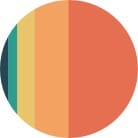

        在RNN的学习中，我们以及得知：短期的记忆影响较大（如橙色区域），但是长期的记忆影响就很小（如黑色和绿色区域），这就是 RNN 存在的短期记忆问题。

        短期记忆问题使得RNN无法处理很长的输入序列。因此，后来又出现了基于 RNN 的优化算法—— LSTM。

        LSTM 做的最大的改变就是打破了这个死板的逻辑，而改用了一套灵活了逻辑——只保留重要的信息。
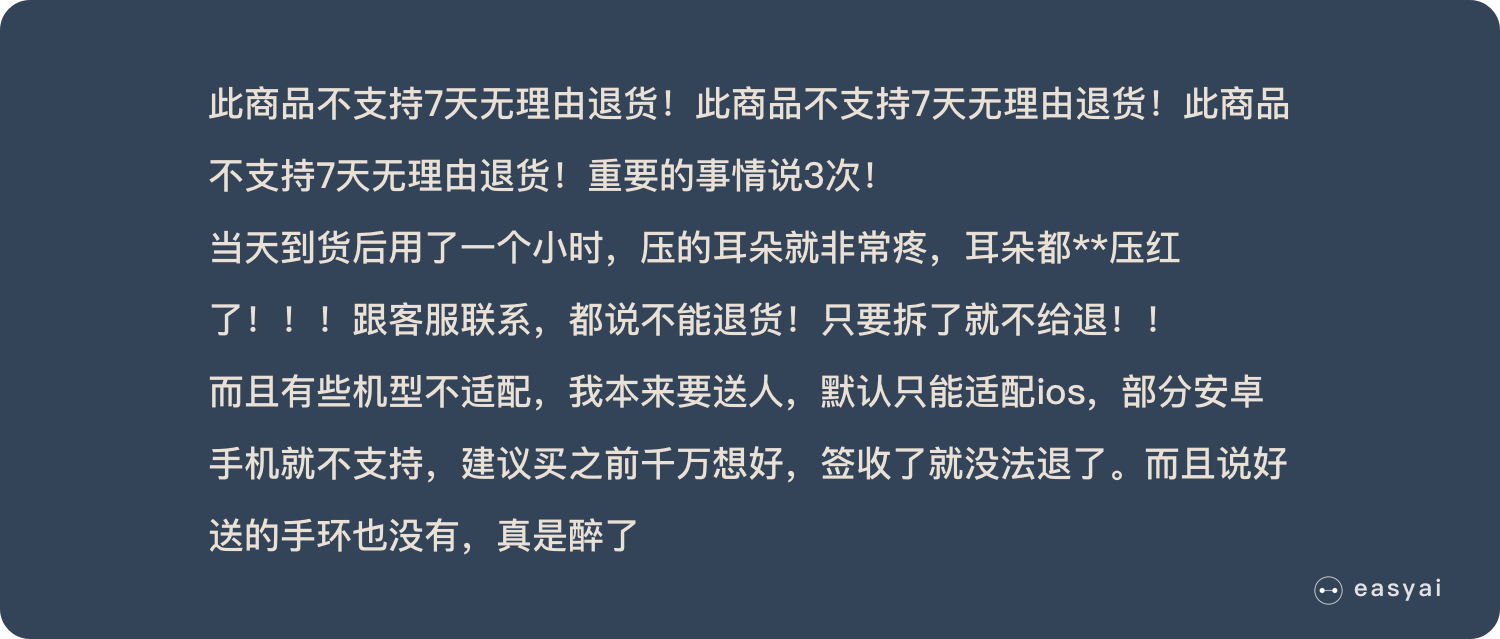
        
        当我们快速阅读完之后，可能只会记住下面几个重点：
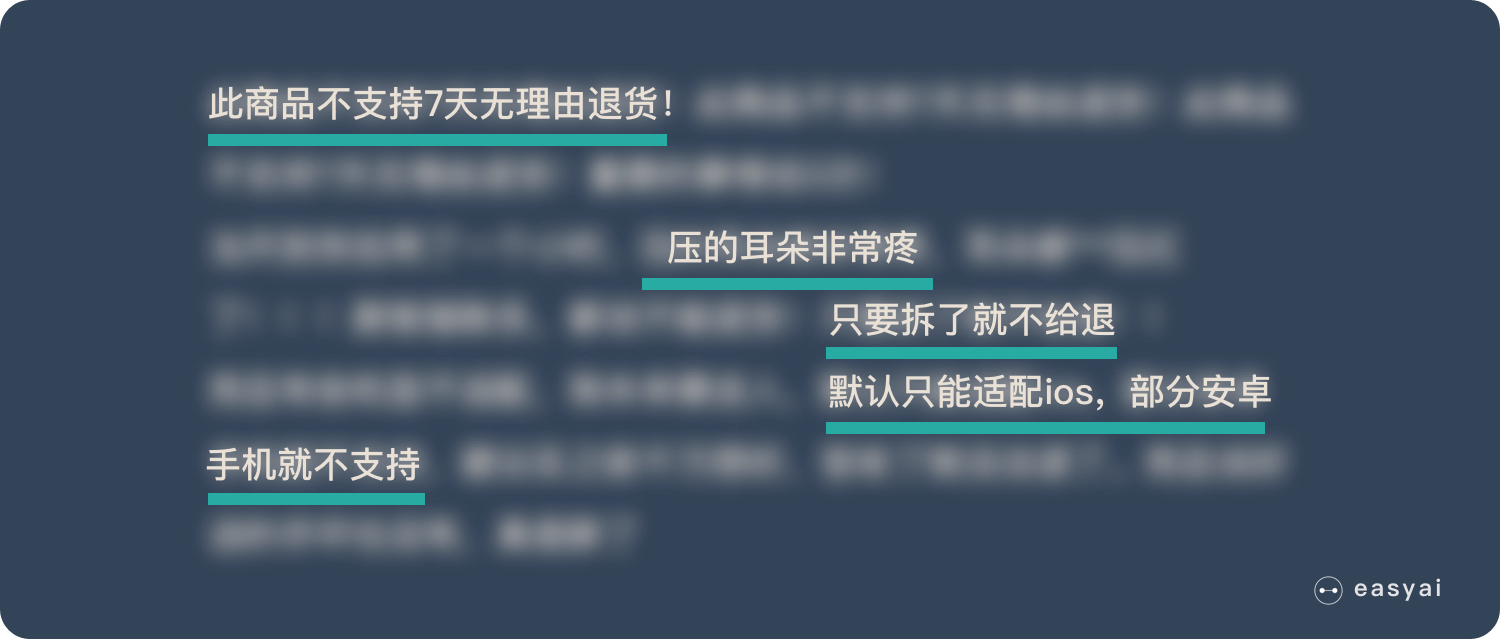

        LSTM 类似上面的划重点，他可以保留较长序列数据中的「重要信息」，忽略不重要的信息。这样就解决了 RNN 短期记忆的问题。

### LSTM保留重要信息的实现原理
        长短期记忆人工神经网络（Long-Short Term Memory,LSTM）论文首次发表于1997年。由于独特的设计结构，LSTM适合于处理和预测时间序列中间隔和延迟非常长的重要事件。
    
        LSTM 也具有RNN类似的链式结构，但重复模块具有不同的结构。不是一个单独的神经网络层，而是四个，并且以非常特殊的方式进行交互。
        LSTM 结构的关键就是理解不同门（Gate）的作用。
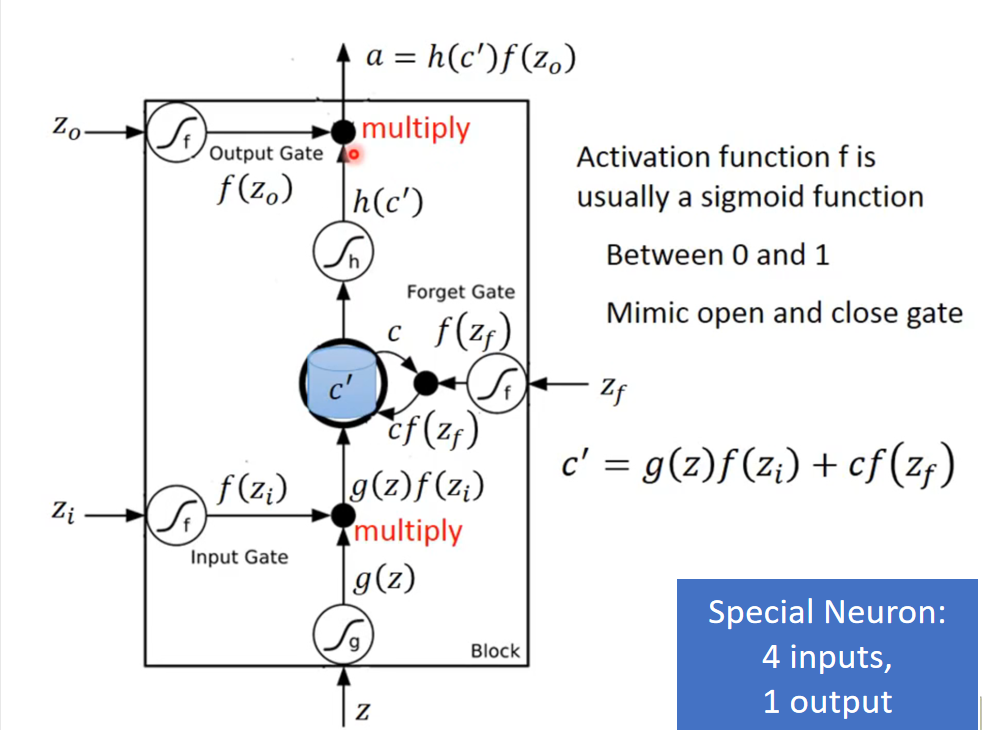
        
### 记忆信息C的传递运算过程 以及 4个输入的计算过程
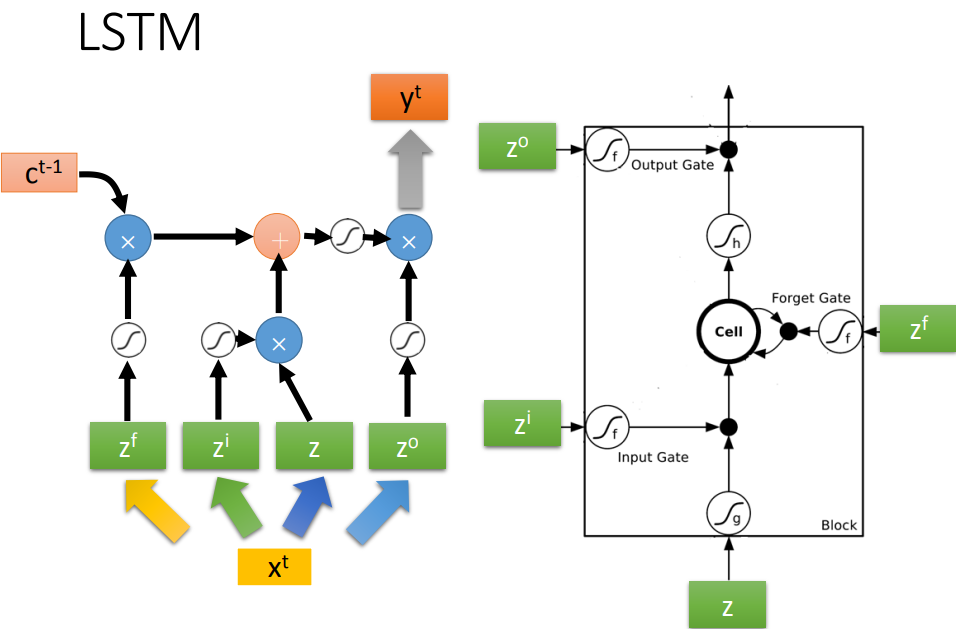

### 网络的展开过程
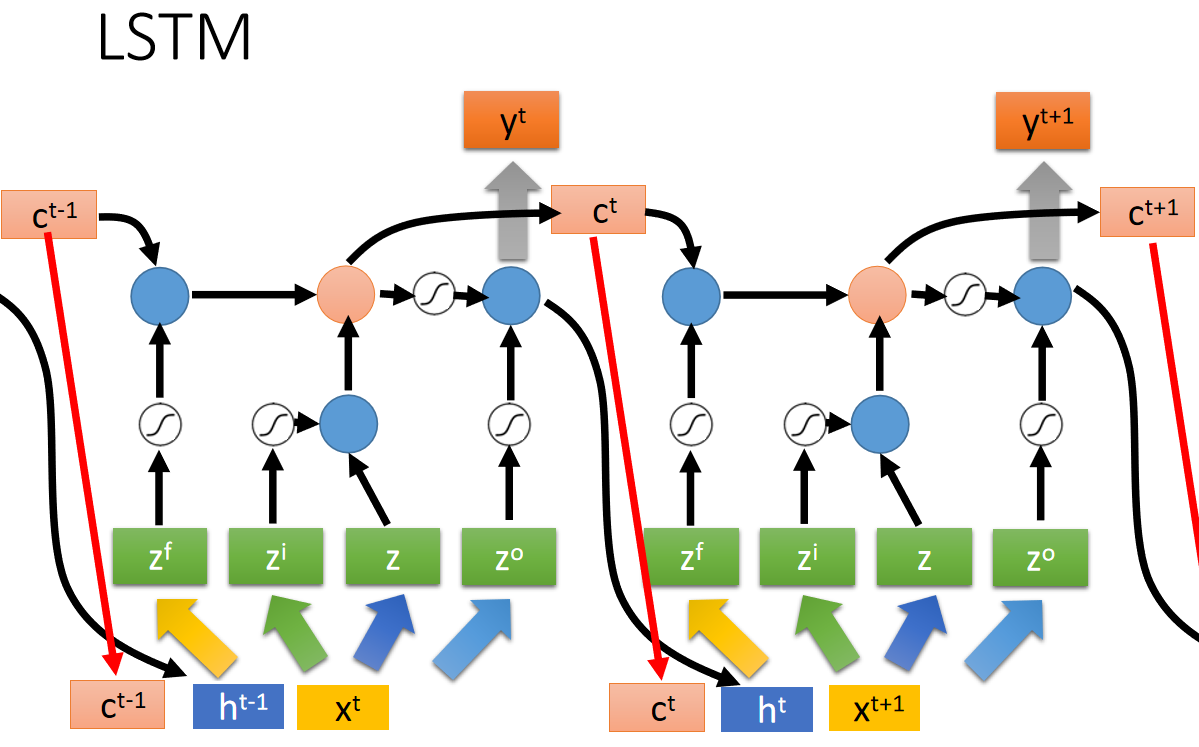

# 使用tensorflow搭建LSTM网络

In [1]:
import glob
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from random import shuffle

def pre_process_data(filepath):
    """
    This is dependent on your training data source but we will try to generalize it as best as possible.
    """
    positive_path = os.path.join(filepath, 'pos')
    negative_path = os.path.join(filepath, 'neg')
    
    pos_label = 1
    neg_label = 0
    
    dataset = []
    
    for filename in glob.glob(os.path.join(positive_path, '*.txt')):
        with open(filename, 'r', encoding='utf-8') as f:
            dataset.append((pos_label, f.read()))
            
    for filename in glob.glob(os.path.join(negative_path, '*.txt')):
        with open(filename, 'r', encoding='utf-8') as f:
            dataset.append((neg_label, f.read()))
    
    shuffle(dataset)
    
    return dataset

In [2]:
from nltk.tokenize import TreebankWordTokenizer
from nlpia.loaders import get_data

word_vectors = get_data('wv') 

def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    expected = []
    for sample in dataset:
        tokens = tokenizer.tokenize(sample[1])
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_vectors[token])

            except KeyError:
                pass  # No matching token in the Google w2v vocab
            
        vectorized_data.append(sample_vecs)

    return vectorized_data

C:\Users\ai\anaconda3\envs\nlp\lib\site-packages\pugnlp\constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
C:\Users\ai\anaconda3\envs\nlp\lib\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
C:\Users\ai\anaconda3\envs\nlp\lib\site-packages\pugnlp\tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
C:\Users\ai\anaconda3\envs\nlp\lib\site-packages\pugnlp\util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
INFO

In [3]:
# 提取标签
def collect_expected(dataset):
    """ Peel of the target values from the dataset """
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected

In [4]:
#  数据填充或截断
def pad_trunc(data, maxlen):
    """ For a given dataset pad with zero vectors or truncate to maxlen """
    new_data = []

    # Create a vector of 0's the length of our word vectors
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)

    for sample in data:
 
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

### 导入数据

In [5]:
import numpy as np

maxlen = 400
batch_size = 32
embedding_dims = 300
epochs = 2

dataset = pre_process_data('C:/Users/ai/anaconda3/envs/tf2/Lib/site-packages/nlpia/bigdata/aclImdb/train')[:16000]
vectorized_data = tokenize_and_vectorize(dataset)
expected = collect_expected(dataset)

split_point = int(len(vectorized_data)*.8)

x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]

x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

### 构建模型

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM

num_neurons = 50

print('Build model...')
model = Sequential()

model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 50)           70200     
                                                                 
 dropout (Dropout)           (None, 400, 50)           0         
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 90,201
Trainable params: 90,201
Non-trainable params: 0
_________________________________________________________________
None


    输入词向量300维，50个神经元，每个神经元有4个输入，以及对应一个记忆单元。

   参数计算：$$(300+50+1)*4*50=70200$$


In [7]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
model_structure = model.to_json()
with open("lstm_model1.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights("lstm_weights1.h5")
print('Model saved.')

Epoch 1/2
400/400 [==============================] - 73s 173ms/step - loss: 0.4941 - accuracy: 0.7591 - val_loss: 0.4215 - val_accuracy: 0.8081
Epoch 2/2
400/400 [==============================] - 44s 109ms/step - loss: 0.3706 - accuracy: 0.8424 - val_loss: 0.3615 - val_accuracy: 0.8422
Model saved.


### 预测效果

In [8]:
from tensorflow.keras.models import model_from_json
with open("lstm_model1.json", "r") as json_file:
    json_string = json_file.read()
model = model_from_json(json_string)

model.load_weights('lstm_weights1.h5')

In [9]:
sample_1 = "I'm hate that the dismal weather that had me down for so long, when will it break! Ugh, when does happiness return?  The sun is blinding and the puffy clouds are too thin.  I can't wait for the weekend."

# We pass a dummy value in the first element of the tuple just because our helper expects it from the way processed the initial data.  That value won't ever see the network, so it can be whatever.
vec_list = tokenize_and_vectorize([(1, sample_1)])

# Tokenize returns a list of the data (length 1 here)
test_vec_list = pad_trunc(vec_list, maxlen)

test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen, embedding_dims))

print("Raw output of sigmoid function: {}".format(model.predict(test_vec)))

Raw output of sigmoid function: [[0.26615787]]


### 优化思想向量大小
我们的循环神经网络的实现，包括简单的RNN和LSTM，都在努力构造一个固定长度 的思想向量，我们可以将其传递到一个前馈层进行分类。一个对象的固定长度的向量表示，如思想向量，通常也被称为嵌入（embedding）。

400 确实是一个有点儿偏高的数字，将 maxlen 调到 202 个词条左右（平均样本大小）。
取其四舍五入值，即 200 个词条

In [10]:
def test_len(data, maxlen):
    total_len = truncated = exact = padded = 0
    for sample in data:
        total_len += len(sample)
        if len(sample) > maxlen:
            truncated += 1
        elif len(sample) < maxlen:
            padded += 1
        else:
            exact +=1 
    print('Padded: {}'.format(padded))
    print('Equal: {}'.format(exact))
    print('Truncated: {}'.format(truncated))
    print('Avg length: {}'.format(total_len/len(data)))

dataset = pre_process_data('C:/Users/ai/anaconda3/envs/tf2/Lib/site-packages/nlpia/bigdata/aclImdb/train')
vectorized_data = tokenize_and_vectorize(dataset)
test_len(vectorized_data, 400)

Padded: 22458
Equal: 20
Truncated: 2522
Avg length: 205.21456


In [11]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM


maxlen = 200
batch_size = 32         
embedding_dims = 300    

epochs = 2

dataset = pre_process_data('C:/Users/ai/anaconda3/envs/tf2/Lib/site-packages/nlpia/bigdata/aclImdb/train')[:16000]
vectorized_data = tokenize_and_vectorize(dataset)
expected = collect_expected(dataset)

split_point = int(len(vectorized_data)*.8)

x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]

x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

num_neurons = 50

print('Build model...')
model = Sequential()

model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200, 50)           70200     
                                                                 
 dropout_1 (Dropout)         (None, 200, 50)           0         
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 80,201
Trainable params: 80,201
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
model_structure = model.to_json()
with open("lstm_model7.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights("lstm_weights7.h5")
print('Model saved.')

Epoch 1/2
400/400 [==============================] - 32s 75ms/step - loss: 0.5059 - accuracy: 0.7510 - val_loss: 0.4424 - val_accuracy: 0.7950
Epoch 2/2
400/400 [==============================] - 29s 73ms/step - loss: 0.3845 - accuracy: 0.8330 - val_loss: 0.3390 - val_accuracy: 0.8584
Model saved.


训练的速度更快，验证精确率基本无影响。并且一个 200 维模型比之前的 400 维模型的泛化能力更好。

In [13]:
from tensorflow.keras.models import model_from_json
with open("lstm_model7.json", "r") as json_file:
    json_string = json_file.read()
model = model_from_json(json_string)

model.load_weights('lstm_weights7.h5')

In [14]:
sample_1 = "I'm hate that the dismal weather that had me down for so long, when will it break! Ugh, when does happiness return?  The sun is blinding and the puffy clouds are too thin.  I can't wait for the weekend."

# We pass a dummy value in the first element of the tuple just because our helper expects it from the way processed the initial data.  That value won't ever see the network, so it can be whatever.
vec_list = tokenize_and_vectorize([(1, sample_1)])

# Tokenize returns a list of the data (length 1 here)
test_vec_list = pad_trunc(vec_list, maxlen)

test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen, embedding_dims))

print("Raw output of sigmoid function: {}".format(model.predict(test_vec)))

Raw output of sigmoid function: [[0.26753226]]


## 字符级建模
在对语言建模时，许多含义隐藏在字符里面。语音语调、头韵、韵律。人类不需要分解得如此细致就可以为语言建模。但是，从建模中产生的定义非常复杂，并不容易传授给机器，这就是我们讨论这个问题的原因。

In [15]:
dataset = pre_process_data('C:/Users/ai/anaconda3/envs/tf2/Lib/site-packages/nlpia/bigdata/aclImdb/train')[:16000]
expected = collect_expected(dataset)

In [16]:
# 计算样本中平均有多少个字符，就能知道网络将要被展开得更远

def avg_len(data):
    total_len = 0
    for sample in data:
        total_len += len(sample[1])
    print(total_len/len(data))

print(avg_len(dataset))

1323.0220625
None


In [17]:
# 我们选择 1500 作为 maxlen 来获得比平均样本长度略多的样本数据

maxlen = 1500

In [18]:
# 清除一些与文本的自然语言无关的词条数据。
def clean_data(data):

    new_data = []
    VALID = 'abcdefghijklmnopqrstuvwxyz123456789"\'?!.,:; '
    for sample in data:
        new_sample = []
        for char in sample[1].lower():  # J只需抓取字符串， 不需要标签
            if char in VALID:
                new_sample.append(char)
            else:
                new_sample.append('UNK')
       
        new_data.append(new_sample)
    return new_data

listified_data = clean_data(dataset)

In [19]:
# 填充和截断字符
def char_pad_trunc(data, maxlen):
    """ We truncate to maxlen or add in PAD tokens """
    new_dataset = []
    for sample in data:
        if len(sample) > maxlen:
            new_data = sample[:maxlen]
        elif len(sample) < maxlen:
            pads = maxlen - len(sample)
            new_data = sample + ['PAD'] * pads
        else:
            new_data = sample
        new_dataset.append(new_data)
    return new_dataset

In [20]:
# 基于字符的模型“字典”
def create_dicts(data):
    """ Modified from Keras LSTM example"""
    chars = set()
    for sample in data:
        chars.update(set(sample))
    char_indices = dict((c, i) for i, c in enumerate(chars))
    indices_char = dict((i, c) for i, c in enumerate(chars))
    return char_indices, indices_char

将使用one_hot编码字符，而不是使用 Word2vec


In [21]:
# 字符的one_hot编码
import numpy as np

def onehot_encode(dataset, char_indices, maxlen):

    X = np.zeros((len(dataset), maxlen, len(char_indices.keys())))
    for i, sentence in enumerate(dataset):
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
    return X

In [22]:
# 加载和预处理 IMDB 数据
common_length_data = char_pad_trunc(listified_data, maxlen)

char_indices, indices_char = create_dicts(common_length_data)
encoded_data = onehot_encode(common_length_data, char_indices, maxlen)

In [23]:
split_point = int(len(encoded_data)*.8)

x_train = encoded_data[:split_point]
y_train = expected[:split_point]
x_test = encoded_data[split_point:]
y_test = expected[split_point:]

In [24]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, LSTM


num_neurons = 40

print('Build model...')
model = Sequential()

model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, len(char_indices.keys()))))
model.add(Dropout(.2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1500, 40)          13920     
                                                                 
 dropout_2 (Dropout)         (None, 1500, 40)          0         
                                                                 
 flatten_2 (Flatten)         (None, 60000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 60001     
                                                                 
Total params: 73,921
Trainable params: 73,921
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
batch_size = 32
epochs = 2
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
model_structure = model.to_json()
with open("char_lstm_model3.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights("char_lstm_weights3.h5")
print('Model saved.')

Epoch 1/2
400/400 [==============================] - 126s 313ms/step - loss: 0.7092 - accuracy: 0.5315 - val_loss: 0.6997 - val_accuracy: 0.5275
Epoch 2/2
400/400 [==============================] - 116s 291ms/step - loss: 0.6052 - accuracy: 0.6784 - val_loss: 0.6986 - val_accuracy: 0.5650
Model saved.


训练集上的精确率高，但测试集上的精确率低，表现模型过拟合，并且训练过程非常耗时。

如果有更多、更广泛的数据集，则字符级模型会非常擅长对语言建模。

### 生成聊天文字
以特定的“风格”生成新的文本。使用训练样本本身，而不是使用训练集的情感标签来作为学习的目标！对于样本中的每个词条，我们希望 LSTM模型能学会预测下一个词条。
所以要调整训练集的标签，输出向量对比的不是给定的分类标签，而是序列中下一个字符的one-hot编码。
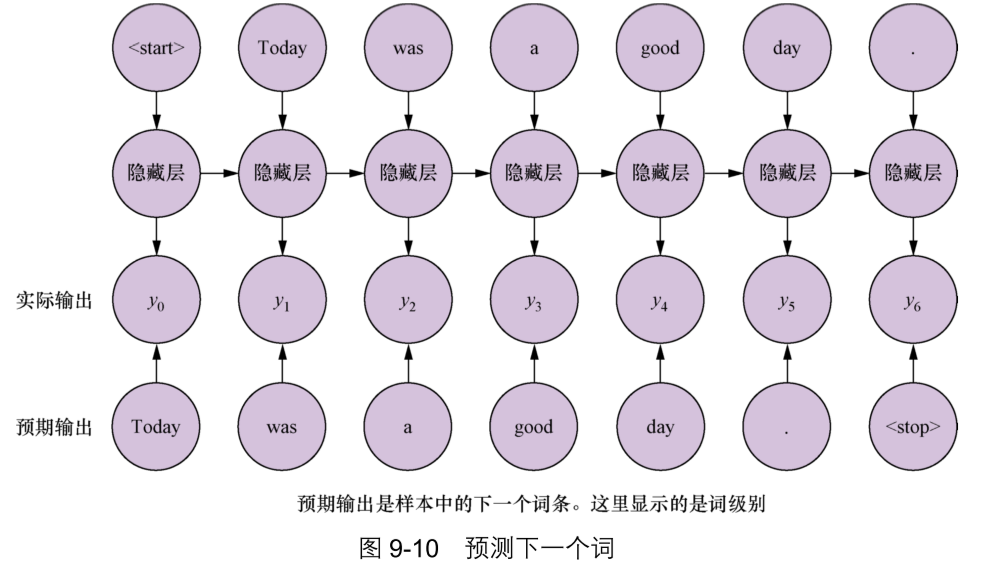

In [27]:
# 导入古腾堡计划数据集
# 包含莎士比亚的 3 部戏剧
from nltk.corpus import gutenberg

print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


### 数据预处理
将莎士比亚的 3 部戏剧拼接成一个大字符串

In [28]:
text = ''
for txt in gutenberg.fileids():
    if 'shakespeare' in txt:
        text += gutenberg.raw(txt).lower()    # 拼接NLTK的古腾堡语料库中 所有的莎士比亚戏剧

print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

corpus length: 375542
total chars: 50


In [29]:
print(text[:500])

[the tragedie of julius caesar by william shakespeare 1599]


actus primus. scoena prima.

enter flauius, murellus, and certaine commoners ouer the stage.

  flauius. hence: home you idle creatures, get you home:
is this a holiday? what, know you not
(being mechanicall) you ought not walke
vpon a labouring day, without the signe
of your profession? speake, what trade art thou?
  car. why sir, a carpenter

   mur. where is thy leather apron, and thy rule?
what dost thou with thy best apparrell on


将把原始文本分成数据样本，每个样本都有固定的 maxlen 个字符

从开头处取 40 个字符，从开头移到第 3 个字符，从那里取 40 个字符，移到第 6 个字符……以此类推。

In [30]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 125168


In [31]:
# 对数据集进行one-hot编码
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

C:\Users\ai\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\ai\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
# 构建一个基于字符的 LSTM模型来生成文本
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
# 使用 categorical_crossentropy 试图使结果的概率分布与独热编码预期字符之间的差异最小化。

print(model.summary())

Build model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               91648     
                                                                 
 dense_3 (Dense)             (None, 50)                6450      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
Total params: 98,098
Trainable params: 98,098
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\ai\anaconda3\envs\nlp\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [33]:
epochs = 6
batch_size = 128

model_structure = model.to_json()
with open("shakes_lstm_model.json", "w") as json_file:
    json_file.write(model_structure)

for i in range(2):
    model.fit(X, y,
              batch_size=batch_size,
              epochs=epochs)

    model.save_weights("shakes_lstm_weights_{}.h5".format(i+1))
    print('Model saved.')

Epoch 1/6
978/978 [==============================] - 36s 35ms/step - loss: 2.0514
Epoch 2/6
978/978 [==============================] - 35s 36ms/step - loss: 1.6954
Epoch 3/6
978/978 [==============================] - 35s 36ms/step - loss: 1.5857
Epoch 4/6
978/978 [==============================] - 35s 36ms/step - loss: 1.5224
Epoch 5/6
978/978 [==============================] - 36s 37ms/step - loss: 1.4794
Epoch 6/6
978/978 [==============================] - 36s 36ms/step - loss: 1.4493
Model saved.
Epoch 1/6
978/978 [==============================] - 36s 37ms/step - loss: 1.4194
Epoch 2/6
978/978 [==============================] - 35s 36ms/step - loss: 1.4045
Epoch 3/6
978/978 [==============================] - 36s 36ms/step - loss: 1.3878
Epoch 4/6
978/978 [==============================] - 36s 37ms/step - loss: 1.3704
Epoch 5/6
978/978 [==============================] - 36s 37ms/step - loss: 1.3587
Epoch 6/6
978/978 [==============================] - 36s 36ms/step - loss: 1.3490
Mod

### 制作剧本
输出向量是描述50 个可能的输出字符上的概率分布的50维向量，由于网络的最后一层是 softmax，因此输出向量将是网络所有可能输出的概率分布。通过查看输出向量中的最大值，我们可以看到网络认为出现概率最高的下一个字符。

In [34]:
### NOT IN CHAPTER, Just to reproduce output

from keras.models import model_from_json

with open('shakes_lstm_model.json', 'r') as f:
    model_json = f.read()
    
model = model_from_json(model_json)
model.load_weights('shakes_lstm_weights_2.h5')

In [35]:
import random

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [36]:
import sys

start_index = random.randint(0, len(text) - maxlen - 1)

for diversity in [0.2, 0.5, 1.0]:
    print()
    print('----- diversity:', diversity)

    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


----- diversity: 0.2
----- Generating with seed: "is in thy hand,
vnbated and envenom'd: t"
is in thy hand,
vnbated and envenom'd: then i haue seene
for the second then your selfe of his sence?
what we will be a man, and when then then i see
is a poore then the selfe in the selfe

   cassi. then i will be the may see the chasted to denter
the senating to the play then the senath,
the season the selfe haue then the mother

   cassi. then i haue soule the senath and be the man,
the things and parting and some to the matter'd
in 

----- diversity: 0.5
----- Generating with seed: "is in thy hand,
vnbated and envenom'd: t"
is in thy hand,
vnbated and envenom'd: then with the cheepes,
the cond neares to the captiuit and storne
to deare, the else done of the cond patience
and take it the most bater speake of is the new,
present hands with them haue his consequence,
or by places of the tertion,
where he do haue them.

exeunt.

  clo. i shall asland and a seasons lord,
not for the morter them 

### GRU 门控神经网络

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(GRU(num_neurons, return_sequences=True, input_shape=X[0].shape))

### 小结
1、使用记忆单元记忆信息使序列的模型更加精确和通用。

2、忘记无关信息很重要。

3、对于即将到来的输入，只需保留部分新信息，而 LSTM可以通过训练找到它。 

4、如果能预测接下来会是什么词，就能从概率分布中生成全新的文本。 

5、基于字符的模型比基于词的模型可以更有效、更成功地从小型的、风格集中的语料库中学习。

6、LSTM思想向量可以捕捉的远远不止是句子中词之和。